# Tutorial

Use data from [ERA5-Land](https://www.ecmwf.int/en/era5-land) to examine time scales of variability in surface variables at the grid point closest to HU Beltsville.

This tutorial is part of [zmoon92/hu-pbl-workshop-2020/tree/master/python-tutorial](https://github.com/zmoon92/hu-pbl-workshop-2020/tree/master/python-tutorial).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import xarray as xr

In [2]:
%matplotlib notebook

plt.rcParams.update({
    "figure.autolayout": True,
    "axes.xmargin": 0,
})

# define some defaults
xrp = {
    "size": 5.2,  # height; if we pass it to xarray plot methods, it will create a new fig
    "aspect": 1.6,  # aspect * size = width
}
figsize = (xrp["size"]*xrp["aspect"], xrp["size"])  # width, height

## Pre

### Load the data

According to [the GRUAN page](https://www.gruan.org/network/sites/beltsville), we want to the point closest to 39.0542 °N, 76.8775 °W. In ERA5-Land, which has a resolution of 0.1°, this turns out to be the point 39.1, -76.9. I have already extracted a few years of data for that point to the file `era5-land_bel.nc`. This file is available if you are running the notebook on the MyBinder for the repo (or have cloned the repo). Otherwise, you will need to download it.

Examine the data set.

You can interact with its fancy HTML representation, which will show up if you have xarray [v0.15.1+](http://xarray.pydata.org/en/stable/whats-new.html#v0-15-1-23-mar-2020).

In [3]:
ds = xr.open_dataset("era5-land_bel.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 35064)
Coordinates:
    latitude   float32 ...
    longitude  float32 ...
  * time       (time) datetime64[ns] 2016-01-01 ... 2019-12-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    d2m        (time) float32 ...
    t2m        (time) float32 ...
    slhf       (time) float32 ...
    ssr        (time) float32 ...
    sp         (time) float32 ...
    sshf       (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-10 05:34:18 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Examine a variable.

In [4]:
ds.t2m

<xarray.DataArray 't2m' (time: 35064)>
array([280.8642 , 280.07727, 279.59888, ..., 283.021  , 281.76385, 280.85602],
      dtype=float32)
Coordinates:
    latitude   float32 39.1
    longitude  float32 -76.9
  * time       (time) datetime64[ns] 2016-01-01 ... 2019-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

### Sample time series plots

<IPython.core.display.Javascript object>


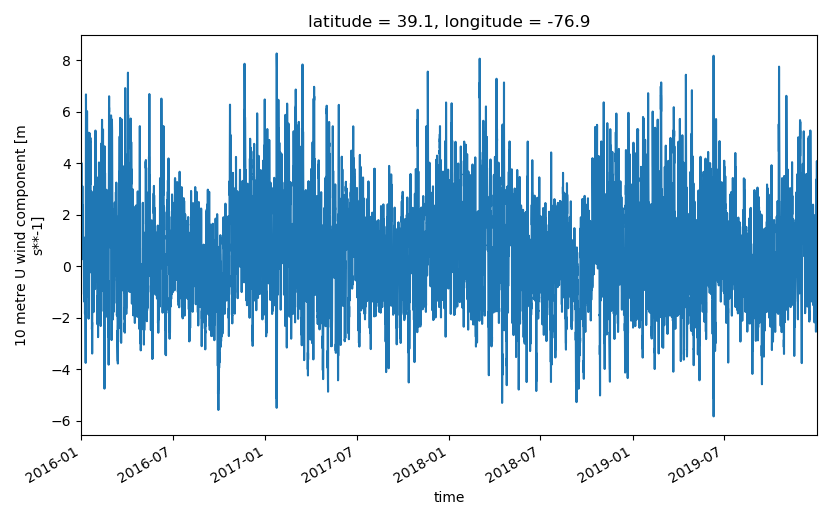

In [5]:
ds.u10.plot.line(**xrp);

Notice how xarray does all of the labeling for us, including units and descriptive name for the variable being plotted. This is possible because the data set we have loaded follows the [CF Conventions](https://cfconventions.org/), specifying `units` and `long_name` attributes for each variable.

<IPython.core.display.Javascript object>


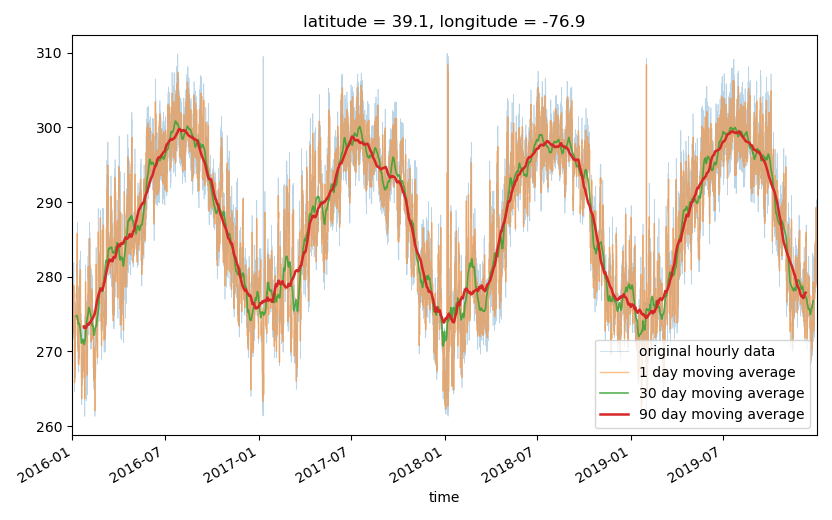

In [6]:
ds.t2m.plot.line(**xrp, lw=0.5, alpha=0.3, label="original hourly data")

# add some moving averages (the time resolution is 1 hour)
ds.t2m.rolling(time=12, center=True).mean().plot(lw=1.0, alpha=0.5, label="1 day moving average")
ds.t2m.rolling(time=12*30, center=True).mean().plot(lw=1.2, alpha=0.8, label="30 day moving average")
ds.t2m.rolling(time=12*90, center=True).mean().plot(lw=1.8, alpha=1.0, label="90 day moving average")
plt.legend();

Relationship between the sensible heat flux and near-surface air temperature?

<IPython.core.display.Javascript object>


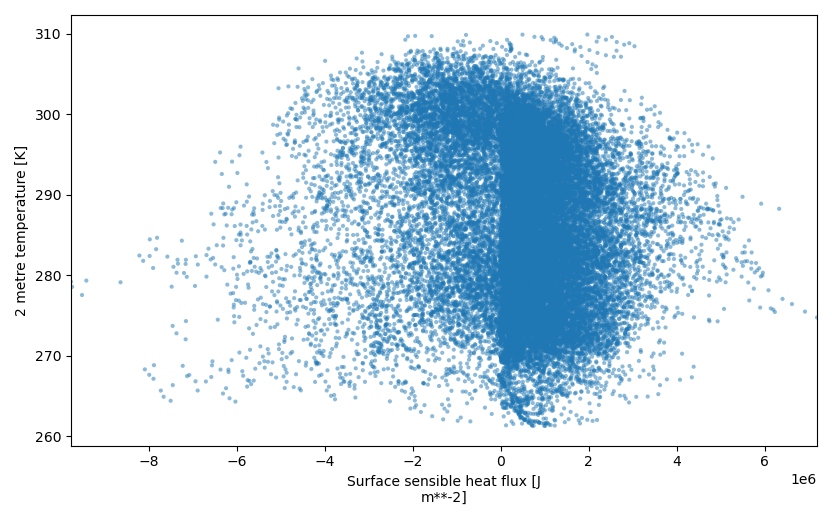

In [7]:
ds.plot.scatter(x="sshf", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);

How about at midday in the summer?

<IPython.core.display.Javascript object>


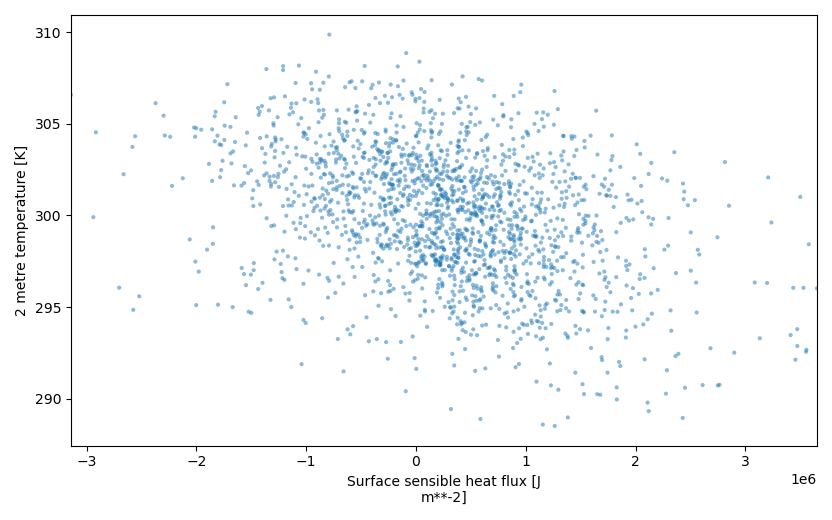

In [8]:
h = ds.time.dt.hour
mo = ds.time.dt.month
ds.where(
    (h >= 14) & (h <= 18) & (mo >= 6) & (mo <= 8)
).plot.scatter(x="sshf", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);

## Tutorial problems

### Compare variables to Sun

Which have the strongest correlation?

We can compute Sun position with [pvlib](https://pvlib-python.readthedocs.io/en/stable/). [Astropy](https://www.astropy.org/) could also be used for this.

In [9]:
sun_pos = pvlib.solarposition.get_solarposition(ds.time.values, ds.latitude.values, ds.longitude.values)
sun_pos

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2016-01-01 00:00:00,113.550494,113.550494,-23.550494,-23.550494,258.674334,-3.070237
2016-01-01 01:00:00,125.086868,125.086868,-35.086868,-35.086868,267.371391,-3.090043
2016-01-01 02:00:00,136.698984,136.698984,-46.698984,-46.698984,277.273908,-3.109842
2016-01-01 03:00:00,147.991273,147.991273,-57.991273,-57.991273,290.380812,-3.129633
2016-01-01 04:00:00,158.009919,158.009919,-68.009919,-68.009919,311.699909,-3.149415
...,...,...,...,...,...,...
2019-12-31 19:00:00,67.197831,67.237473,22.802169,22.762527,207.285934,-2.982273
2019-12-31 20:00:00,73.654821,73.711018,16.345179,16.288982,220.217119,-3.002181
2019-12-31 21:00:00,81.951171,82.061483,8.048829,7.938517,231.453267,-3.022080
2019-12-31 22:00:00,91.748073,91.748073,-1.748073,-1.748073,241.294639,-3.041970


Add some of the Sun position variables to our data set.

In [10]:
zen_deg = sun_pos["zenith"]
zen = zen_deg.apply(np.deg2rad)
ds["sza"] = ("time", zen_deg, {"long_name": "solar zenith angle", "units": "deg"})
ds["mu"] = ("time", zen.apply(np.cos), {"long_name": "cos(sza)", "units": ""})
ds["selev"] = ("time", sun_pos["elevation"], {"long_name": "solar elevation angle", "units": "deg"})

<IPython.core.display.Javascript object>


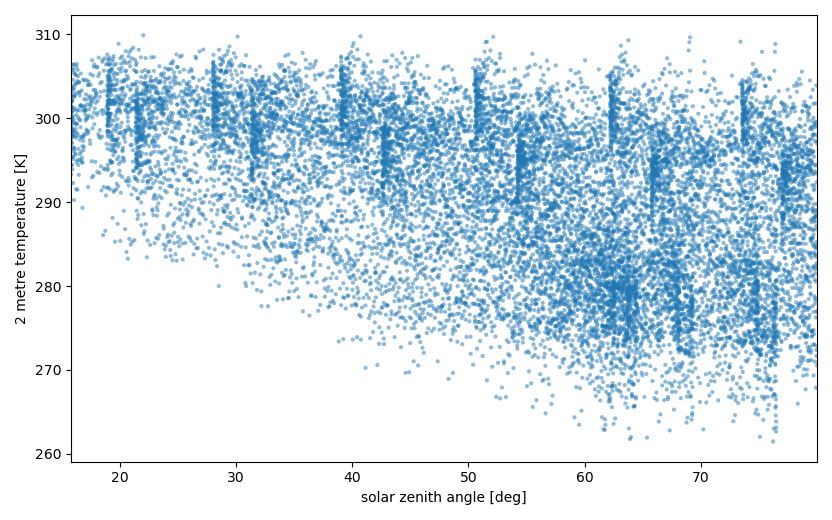

In [11]:
day = ds.time.where(ds.selev > 10).dropna("time")

ds.sel(time=day).plot.scatter(x="sza", y="t2m", marker=".", alpha=0.5, edgecolors="none", **xrp);